In [1]:
%%capture

%cd ..
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:
import itertools
from pathlib import Path

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from heatmap import heatmap, corrplot
from ipywidgets import interact, fixed, interact_manual
from wordcloud import WordCloud

sns.set()
nltk.download('stopwords')

pd.set_option('expand_frame_repr', True)
pd.set_option('display.column_space', 6)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.show_dimensions', True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/limagbz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis

This notebook can be used to reproduce the exploratory data analysis.

## Setup

In [56]:
PROCESSED_DATA_FOLDER = Path('data/processed/')

## Data Loading

In [4]:
data_df = pd.read_csv(PROCESSED_DATA_FOLDER/"fake_true_news_cleaned_features.csv", index_col=0)
data_df["class"] = data_df["class"].astype('category')

CONTINUOUS_VARIABLES = [x for x, y in data_df.dtypes.iteritems() if str(y) not in ('category', 'object')]

## Correlation Analysis

### Correlation Matrix

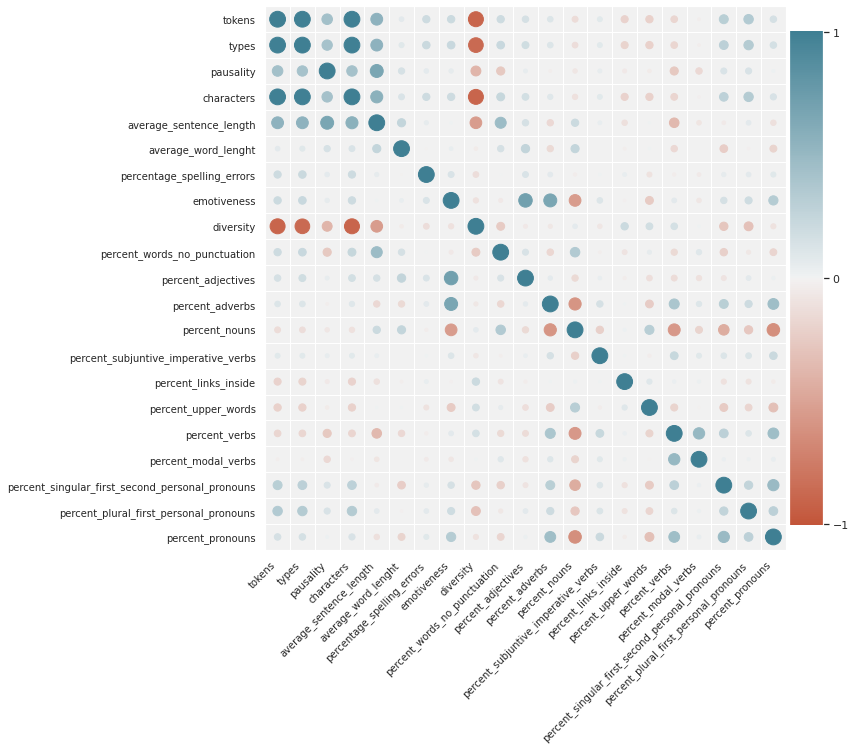

In [5]:
fig = plt.figure(figsize=(10, 10))
corrplot(data_df[CONTINUOUS_VARIABLES].corr(method="spearman"), size_scale=250, marker='o')
fig.axes[0].tick_params(axis="x", labelsize=10)
fig.axes[0].tick_params(axis="y", labelsize=10)
fig.axes[1].tick_params(axis="x", labelsize=10)
fig.axes[1].tick_params(axis="x", labelsize=10)

The image above shows the correlation of the continuous variables present in the dataset. The area and the color hue represents the magnitude of correlation. What can be observed here is:

* Great positive correlations between tokens, types and characters as expected since these values increase together and are not normalized
* Great negative correlation between diversity and tokens, types and characters as expected too, since diversity is calculated as the number of different words {{TODO: CHECAR SE ISSO é REALIDADE}}

To help investigate the correlations we can look at the top and lowest correlations. To achieve this we made some custom functions and use some widgets

In [6]:
def get_top_abs_correlations(df, method="spearman"):
    
    # Drop redundant pairs of columns
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    
    # Calculate Correlation
    au_corr = df.corr(method=method).unstack()
    au_corr = au_corr.drop(labels=pairs_to_drop)
    
    return au_corr

Now, let's calculate the correlation

In [7]:
correlation_data = get_top_abs_correlations(data_df[CONTINUOUS_VARIABLES])

The top correlations are

In [8]:
top_pos_corr = correlation_data[correlation_data >= 0].sort_values(ascending=False)[0:10]
top_neg_corr = correlation_data[correlation_data <= 0].sort_values(ascending=True)[0:10]

t = pd.DataFrame(pd.concat([top_pos_corr, top_neg_corr], keys=['positive', 'negative']))
t.style.bar(subset=[0], align='mid', color=['#d65f5f', '#5fba7d'])

On the table above what we can see is:

* {{FAZER CONCLUSOES}} --> Correlação alta acima de 0.75

Let's also see the joint plots. To easy the visualization we are going to a widget

In [9]:
def continuous_jointplot(df, variable_x, variable_y, kwargs):
    sns.jointplot(x=variable_x, y=variable_y, data=df, hue='class', **kwargs)
    plt.show()

interact_manual(
    continuous_jointplot, variable_x=CONTINUOUS_VARIABLES, variable_y=CONTINUOUS_VARIABLES, 
    df=fixed(data_df), kwargs=fixed({}),
)

interactive(children=(Dropdown(description='variable_x', options=('tokens', 'types', 'pausality', 'characters'…

<function __main__.continuous_jointplot(df, variable_x, variable_y, kwargs)>

Here we conclude that {{TODO: CONCLUSOES}}

## Distribution

Now let's compare the distributions for both classes.

In [51]:
def continuous_univariate_plots(df, variable, jitter, hue='class', figsize=(30,5)):

    # Preparing Data
    df["all"] = ""
    
    # Setup Figure
    N_ROWS, N_COLUMNS = 2, 4
    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'{variable} (n={len(df)})')
    
    ax1 = plt.subplot2grid((N_ROWS, N_COLUMNS), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((N_ROWS, N_COLUMNS), (0, 1), colspan=1)
    ax3 = plt.subplot2grid((N_ROWS, N_COLUMNS), (0, 2), colspan=1)
    ax4 = plt.subplot2grid((N_ROWS, N_COLUMNS), (0, 3), colspan=1)
    ax5 = plt.subplot2grid((N_ROWS, N_COLUMNS), (1, 0), colspan=2)
    ax6 = plt.subplot2grid((N_ROWS, N_COLUMNS), (1, 2), colspan=2)
    
    # Plots: Distribution plot
    mean, mode, median = df[variable].mean(), df[variable].mode()[0], df[variable].median()
    sns.histplot(x=variable, hue=hue, data=df, ax=ax1)
    ax1.axvline(mean, color='r', linestyle='--')
    ax1.axvline(mode, color='g', linestyle='-')
    ax1.axvline(median, color='y', linestyle='-')
    ax1.legend({'Mean': mean, 'Median': median, 'Mode': mode})
    ax1.set_title("Distribution Plot (skew=%.2f, kurt=%.2f)" %(df[variable].skew(), df[variable].kurtosis()))
    
    # Plots: Violin & Jitter 
    sns.violinplot(x=variable, y="all", hue=hue, data=df, cut=True, split=True, vars=df.columns, ax=ax2)
    if jitter == "strip": 
        sns.stripplot(x=variable, y="all", data=df, hue=hue, ax=ax2, alpha=.25)
    elif jitter == "swarm":
        sns.swarmplot(x=variable, y="all", data=df, hue=hue, ax=ax2, alpha=.25)
    ax2.set_title("Violin Plot")
    ax2.set_ylabel("")
    
    # Plots: Boxplot
    sns.boxplot(x=variable, y='all', data=df, ax=ax3, hue=hue)
    ax3.set_title("Box-and-Whisker Plot")
    
    # Plots: Boxen Plot
    sns.boxenplot(x=variable, y='all', data=df, showfliers=True, hue=hue, ax=ax4)
    ax4.set_title("Boxen Plot")
    
    # Plots: Probability Plot
    stats.probplot(df[variable], dist='norm', fit=True, plot=ax5)
    ax5.set_title("Probability Plot")
    
    # Plots: Index Plot
    ax6.plot(df[variable], ".")
    ax6.set_title("Index Plot")
    ax6.set_xlabel("Row Index")
    ax6.set_ylabel("Value")
    
    # Remove Modifications on Data
    df.drop(columns=['all'])
    
    # Show Plot
    plt.show()
    
interact_manual(
    continuous_univariate_plots, 
    variable=CONTINUOUS_VARIABLES, 
    jitter=[None, "strip", "swarm"], 
    hue=[None] + list(data_df.columns) ,
    df=fixed(data_df), 
    figsize=fixed((25,12))
)

interactive(children=(Dropdown(description='variable', options=('tokens', 'types', 'pausality', 'characters', …

<function __main__.continuous_univariate_plots(df, variable, jitter, hue='class', figsize=(30, 5))>

## Word Cloud

First, let's tokenize the corpus

In [52]:
list_of_words_fake = ' '.join(list(data_df[data_df["class"] == 'Fake'].text))
list_of_words_fake = [word for word in list_of_words_fake.split(" ") if word not in nltk.corpus.stopwords.words('portuguese')]

list_of_words_true = ' '.join(list(data_df[data_df["class"] == 'True'].text))
list_of_words_true = [word for word in list_of_words_true.split(" ") if word not in nltk.corpus.stopwords.words('portuguese')]

And than plot the data, First for fake news:

### Fake News

(-0.5, 399.5, 199.5, -0.5)

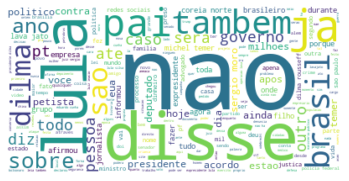

In [58]:
fake_wordcloud = WordCloud(max_words=1000, background_color="white").generate(" ".join(list_of_words_fake))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

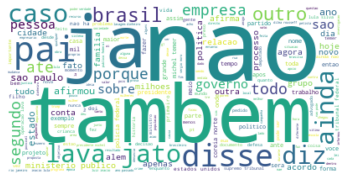

In [59]:
true_wordcloud = WordCloud(max_words=1000, background_color="white").generate(" ".join(list_of_words_true))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis("off")

## EXPORT

In [57]:
FIGURES_PATH = Path("reports/figures/eda")
FIGURES_PATH.mkdir(exist_ok=True, parents=True)

# continuous_jointplot
# Distributions
# WORDCLOUD
# Correlation
# wordcloud.to_file(SAVEFIG_FOLDER/'wordcloudfake.png')
# wordcloud.to_file(SAVEFIG_FOLDER/'wordcloudtrue.png')